<a href="https://colab.research.google.com/github/ngabo-dev/sentiment-analysis_group3/blob/main/TamandaKaunda_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Cleaning & Extraction for Sentiment Analysis (Amazon Reviews)
# - Uses content/Reviews.csv
# - Produces TF-IDF features and tokenized sequences
# - Saves train/val/test splits and artifacts in processed_data/



import os
import re
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# NLTK setup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def _ensure_nltk():
    try:
        _ = stopwords.words("english")
    except LookupError:
        nltk.download("stopwords")
    try:
        _ = nltk.data.find("corpora/wordnet")
    except LookupError:
        nltk.download("wordnet")
    try:
        _ = nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt")

_ensure_nltk()
STOP_WORDS = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



1) Load dataset (Amazon Reviews)


In [2]:

def load_dataset():
    candidates = [
        os.path.join("content", "Reviews.csv"),
        os.path.join("content", "dataset_part1_random_70pct.csv"),
    ]
    for path in candidates:
        if os.path.exists(path):
            print(f"Loading dataset: {path}")
            df = pd.read_csv(path)
            return df, path
    raise FileNotFoundError("No dataset found in 'content/'. Expected Reviews.csv")



In [3]:
# -----------------------------
# 2) Normalize columns and labels
# -----------------------------
def normalize_and_label(df):
    # Expecting columns: 'Text' and 'Score'
    # Map Score 1-2 -> 0 (negative), 4-5 -> 1 (positive), drop 3 (neutral)
    text_col = None
    for c in ["Text", "text", "reviewText", "ReviewText", "review", "Review"]:
        if c in df.columns:
            text_col = c
            break
    if text_col is None:
        raise ValueError("Could not find text column. Expected 'Text' in Reviews.csv")

    if "Score" not in df.columns:
        # If alternative sentiment column exists, try mapping
        if "Sentiment" in df.columns:
            df = df.rename(columns={text_col: "text", "Sentiment": "sentiment"})
            df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})
            df = df.dropna(subset=["text", "label"])
            return df[["text", "label"]]
        else:
            raise ValueError("Expected 'Score' column for Amazon Reviews dataset")

    df = df.rename(columns={text_col: "text"})
    df = df[["text", "Score"]].dropna(subset=["text", "Score"])
    # Drop neutral 3
    df = df[df["Score"] != 3]
    df["label"] = (df["Score"] >= 4).astype(int)
    df = df.drop(columns=["Score"]).reset_index(drop=True)
    return df



In [4]:
# -----------------------------
# 3) Text cleaning
# -----------------------------
def clean_text(s: str) -> str:
    s = str(s)
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)            # HTML tags
    s = re.sub(r"http\S+|www\.\S+", " ", s)   # URLs
    s = re.sub(r"[^a-z\s]", " ", s)           # keep letters and space
    s = re.sub(r"\s+", " ", s).strip()
    return s

def lemmatize_and_filter(s: str) -> str:
    tokens = s.split()  # simple fast tokenization on whitespace
    kept = []
    for t in tokens:
        if t in STOP_WORDS:
            continue
        if len(t) < 3:
            continue
        kept.append(LEMM.lemmatize(t))
    return " ".join(kept)

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    print("Cleaning text...")
    df = df.copy()
    df["clean"] = df["text"].apply(clean_text)
    print("Lemmatizing and removing stopwords...")
    df["proc"] = df["clean"].apply(lemmatize_and_filter)
    # drop empty after processing
    df = df[df["proc"].str.len() > 0].reset_index(drop=True)
    return df



In [5]:
# -----------------------------
# 4) Split into train/val/test
# -----------------------------
def stratified_splits(df, test_size=0.2, val_size=0.1, seed=42):
    y = df["label"].values
    X = df["proc"].values

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=seed
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



In [6]:
# -----------------------------
# 5) TF-IDF features (for ML models)
# -----------------------------
def build_tfidf(X_train, X_val, X_test, max_features=30000):
    vect = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.98
    )
    Xtr = vect.fit_transform(X_train)
    Xv = vect.transform(X_val)
    Xte = vect.transform(X_test)
    return Xtr, Xv, Xte, vect

# -----------------------------
# 6) Simple tokenizer + sequences (for DL models)
# -----------------------------
def build_vocab(texts, max_words=50000, min_freq=2):
    from collections import Counter
    cnt = Counter()
    for s in texts:
        cnt.update(s.split())
    # keep tokens by freq
    vocab = [w for w, f in cnt.items() if f >= min_freq]
    vocab.sort(key=lambda w: (-cnt[w], w))
    vocab = vocab[:max_words]
    word_index = {w: i+1 for i, w in enumerate(vocab)}  # 0 reserved for PAD
    return word_index, cnt

def texts_to_padded_sequences(texts, word_index, max_len=200):
    seqs = []
    for s in texts:
        ids = [word_index.get(w, 0) for w in s.split()]
        if len(ids) >= max_len:
            ids = ids[:max_len]
        else:
            ids = ids + [0] * (max_len - len(ids))
        seqs.append(ids)
    return np.array(seqs, dtype=np.int32)



In [7]:

import os, json, numpy as np
from scipy import sparse
import pickle

os.makedirs("processed_data", exist_ok=True)

# 1) Load + normalize
df_raw, used_path = load_dataset()
df = normalize_and_label(df_raw)
df = preprocess_dataframe(df)

# Persist cleaned dataset
cleaned_path = os.path.join("processed_data", "processed_dataset.csv")
df[["text", "proc", "label"]].to_csv(cleaned_path, index=False, encoding="utf-8")
print(f"Saved cleaned dataset -> {cleaned_path}")

# 2) Splits
(X_train, y_train), (X_val, y_val), (X_test, y_test) = stratified_splits(
    df, test_size=0.2, val_size=0.1, seed=42
)
print(f"Splits -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

# 3) TF-IDF (for Logistic Regression)
Xtr_tfidf, Xv_tfidf, Xte_tfidf, tfidf_vect = build_tfidf(X_train, X_val, X_test, max_features=30000)
sparse.save_npz(os.path.join("processed_data", "X_train_tfidf.npz"), Xtr_tfidf)
sparse.save_npz(os.path.join("processed_data", "X_val_tfidf.npz"),   Xv_tfidf)
sparse.save_npz(os.path.join("processed_data", "X_test_tfidf.npz"),  Xte_tfidf)
with open(os.path.join("processed_data", "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf_vect, f)
print("Saved TF-IDF features and vectorizer.")

# 4) Sequences (for RNN/LSTM)
word_index, _ = build_vocab(X_train, max_words=50000, min_freq=2)
with open(os.path.join("processed_data", "word_index.json"), "w", encoding="utf-8") as f:
    json.dump(word_index, f)

max_len = 200
Xtr_seq = texts_to_padded_sequences(X_train, word_index, max_len=max_len)
Xv_seq  = texts_to_padded_sequences(X_val,   word_index, max_len=max_len)
Xte_seq = texts_to_padded_sequences(X_test,  word_index, max_len=max_len)
np.save(os.path.join("processed_data", "X_train_seq.npy"), Xtr_seq)
np.save(os.path.join("processed_data", "X_val_seq.npy"),   Xv_seq)
np.save(os.path.join("processed_data", "X_test_seq.npy"),  Xte_seq)
print("Saved tokenized padded sequences.")

# 5) Labels
np.save(os.path.join("processed_data", "y_train.npy"), y_train)
np.save(os.path.join("processed_data", "y_val.npy"),   y_val)
np.save(os.path.join("processed_data", "y_test.npy"),  y_test)
print("Saved labels.")

# 6) Embedding matrix (GloVe if available, else random)
glove_path = os.path.join("content", "glove.6B.100d.txt")
embed_dim = 100
vocab_size = (max(word_index.values()) + 1) if word_index else 1
rng = np.random.default_rng(42)
emb = rng.normal(scale=0.02, size=(vocab_size, embed_dim)).astype(np.float32)
emb[0] = 0.0  # PAD row

if os.path.exists(glove_path):
    print(f"Loading GloVe from {glove_path} ...")
    found = 0
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            token, vec = parts[0], parts[1:]
            if len(vec) != embed_dim:
                continue
            if token in word_index:
                emb[word_index[token]] = np.asarray(vec, dtype=np.float32)
                found += 1
    print(f"GloVe matches: {found}/{vocab_size-1}")
else:
    print("GloVe not found. Using random embeddings.")

np.save(os.path.join("processed_data", "embedding_matrix_glove100.npy"), emb)
print("Saved embedding matrix.")

# --------- Minimal quick check ---------
X_train_tfidf = sparse.load_npz(os.path.join("processed_data", "X_train_tfidf.npz"))
X_val_tfidf   = sparse.load_npz(os.path.join("processed_data", "X_val_tfidf.npz"))
X_test_tfidf  = sparse.load_npz(os.path.join("processed_data", "X_test_tfidf.npz"))

X_train_seq = np.load(os.path.join("processed_data", "X_train_seq.npy"))
X_val_seq   = np.load(os.path.join("processed_data", "X_val_seq.npy"))
X_test_seq  = np.load(os.path.join("processed_data", "X_test_seq.npy"))
emb         = np.load(os.path.join("processed_data", "embedding_matrix_glove100.npy"))

y_train = np.load(os.path.join("processed_data", "y_train.npy"))
y_val   = np.load(os.path.join("processed_data", "y_val.npy"))
y_test  = np.load(os.path.join("processed_data", "y_test.npy"))

print("\nLoaded artifacts:")
print("- TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)
print("- Seq shapes:",   X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("- Embedding:",    emb.shape)
print("- y sizes:",      y_train.shape, y_val.shape, y_test.shape)

Loading dataset: content/Reviews.csv
Cleaning text...
Lemmatizing and removing stopwords...
Saved cleaned dataset -> processed_data/processed_dataset.csv
Splits -> train: 49842, val: 7121, test: 14241
Saved TF-IDF features and vectorizer.
Saved tokenized padded sequences.
Saved labels.
GloVe not found. Using random embeddings.
Saved embedding matrix.

Loaded artifacts:
- TF-IDF shapes: (49842, 30000) (7121, 30000) (14241, 30000)
- Seq shapes: (49842, 200) (7121, 200) (14241, 200)
- Embedding: (20530, 100)
- y sizes: (49842,) (7121,) (14241,)


## RNN Model

In [25]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data from the 'processed_data' directory
data_dir = "processed_data"

X_train_seq = np.load(os.path.join(data_dir, "X_train_seq.npy"))
X_val_seq = np.load(os.path.join(data_dir, "X_val_seq.npy"))
X_test_seq = np.load(os.path.join(data_dir, "X_test_seq.npy"))

y_train = np.load(os.path.join(data_dir, "y_train.npy"))
y_val = np.load(os.path.join(data_dir, "y_val.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))

emb = np.load(os.path.join(data_dir, "embedding_matrix_glove100.npy"))

print("Loaded sequence data shapes:")
print(f"X_train_seq: {X_train_seq.shape}, y_train: {y_train.shape}")
print(f"X_val_seq:   {X_val_seq.shape}, y_val:   {y_val.shape}")
print(f"X_test_seq:  {X_test_seq.shape}, y_test:  {y_test.shape}")
print(f"Embedding matrix shape: {emb.shape}")


Loaded sequence data shapes:
X_train_seq: (49842, 200), y_train: (49842,)
X_val_seq:   (7121, 200), y_val:   (7121,)
X_test_seq:  (14241, 200), y_test:  (14241,)
Embedding matrix shape: (20530, 100)


In [26]:
# Data dimensions from loaded data
vocab_size = emb.shape[0]
embed_dim = emb.shape[1]
max_len = X_train_seq.shape[1]

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        weights=[emb],
        input_length=max_len,
        trainable=True  # Fine-tune the pre-trained GloVe weights
    ),
    # Bidirectional SimpleRNN to capture context from both directions
    Bidirectional(SimpleRNN(64, kernel_regularizer=l2(0.001))),
    Dense(64, activation='relu'),
    Dropout(0.5), # Add dropout for regularization
    Dense(1, activation='sigmoid')
])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 200, 100)       │     2,053,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,082,441 (7.94 MB)

 Trainable params: 2,082,441 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model using the loaded sequences and labels
history = model.fit(
    X_train_seq,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_seq, y_val)
)


Epoch 1/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 130s 161ms/step - accuracy: 0.9662 - loss: 0.1243 - val_accuracy: 0.9032 - val_loss: 0.2930
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 122s 157ms/step - accuracy: 0.9674 - loss: 0.1191 - val_accuracy: 0.9094 - val_loss: 0.2799
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 124s 160ms/step - accuracy: 0.9656 - loss: 0.1140 - val_accuracy: 0.9160 - val_loss: 0.3285
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.9693 - loss: 0.1129 - val_accuracy: 0.9134 - val_loss: 0.3357
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 123s 158ms/step - accuracy: 0.9749 - loss: 0.0943 - val_accuracy: 0.9070 - val_loss: 0.3622
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9739 - loss: 0.0954 - val_accuracy: 0.8875 - val_loss: 0.3495
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9742 - loss: 0.0950 - val_accuracy: 0.9072 - val_loss: 0.3698
Epoch 8/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 125s 161ms/step - accuracy: 0.9647 -

In [30]:
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


446/446 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9016 - loss: 0.4292
Test Loss: 0.4216
Test Accuracy: 0.9020


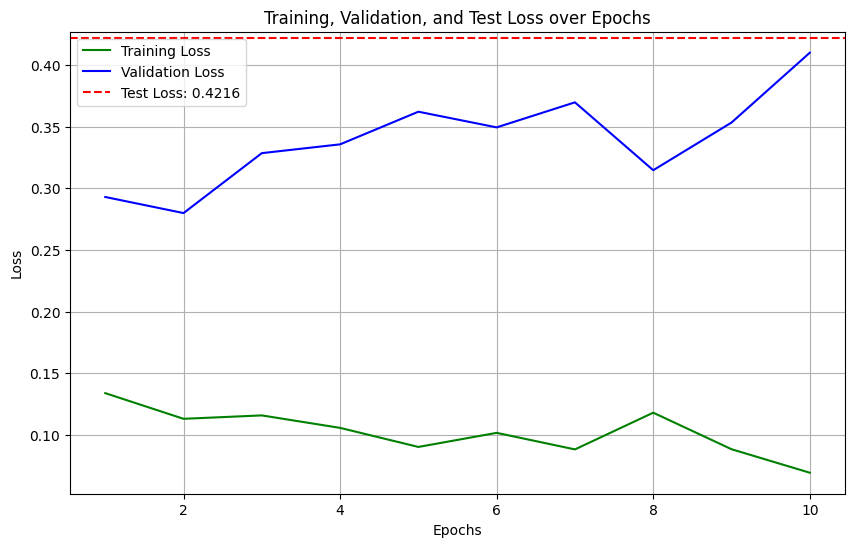

In [35]:
import matplotlib.pyplot as plt

# Create a figure and axis object for plotting
plt.figure(figsize=(10, 6))

# Get the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

# Plot a horizontal line for the final test loss
plt.axhline(y=loss, color='r', linestyle='--', label=f'Test Loss: {loss:.4f}')

# Customize the plot
plt.title('Training, Validation, and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()